In [1]:
from cortexlib.utils import file as futils
from cortexlib.mouse import CortexlabMouse
from cortexlib.images import CortexlabImages
from cortexlib.simclr import PreTrainedSimCLRModel
from cortexlib.predictor import NeuralResponsePredictor
from cortexlib.utils.plotting import simclr_colours
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.logging import Logger
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

14:53:31 | INFO     | ℹ️ This notebook is running for mouse m01_d2


In [3]:
mouse = CortexlabMouse(mouse_id=MOUSE_ID)

logger.progress(f"Computing null distributions for all neurons in mouse {mouse.id}")
null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
logger.success(f"Null distributions computed")

real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

logger.info(f"Neural responses shape: {neural_responses.shape}")

14:53:31 | INFO     | ⏳ Computing null distributions for all neurons in mouse m01_d2...
14:53:57 | SUCCESS  | ✅ Null distributions computed!
14:53:57 | INFO     | ℹ️ Neural responses shape: (1380, 2, 500)


In [4]:
pca = PCA(100)
neural_data_pcs = pca.fit_transform(neural_responses_mean)
pc1_neural_data = neural_data_pcs[:, 0]
print(pc1_neural_data.shape)

(1380,)


In [5]:
futils.save_filtered_neural_data(
    mouse_id=mouse.id,
    neural_responses=neural_responses,
    neural_responses_mean=neural_responses_mean)

14:53:57 | INFO     | ℹ️ Skipping save, file already exists at /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m01_d2/_neural_data/neural_data_mouse_m01_d2.pt


In [6]:
simclr = PreTrainedSimCLRModel()

settings = simclr.get_image_settings()
images = CortexlabImages(
    size=settings['size'],
    channels=settings['channels'],
    normalise_mean=settings['mean'], 
    normalise_std=settings['std'],
    rescale_per_image=settings['rescale_per_image'],
)

logger.progress("Loading and preprocessing images shown to mouse")
image_dataset = images.load_images_shown_to_mouse(mouse.image_ids)
logger.success("Images processed")

14:53:57 | INFO     | ℹ️ Already downloaded pretrained SimCLR model
14:53:57 | INFO     | ⏳ Loading and preprocessing images shown to mouse...
14:54:12 | SUCCESS  | ✅ Images processed!


In [7]:
logger.progress("SimCLR: extracting features from images shown to mouse")
simclr_feats, labels = simclr.extract_features(image_dataset)
logger.success("SimCLR features extracted")

for layer, feats in simclr_feats.items():
    logger.info(f"{layer} feats shape: {tuple(feats.shape)}")

14:54:12 | INFO     | ⏳ SimCLR: extracting features from images shown to mouse...


  0%|          | 0/22 [00:00<?, ?it/s]

14:54:26 | SUCCESS  | ✅ SimCLR features extracted!
14:54:26 | INFO     | ℹ️ layer1 feats shape: (1380, 64, 24, 24)
14:54:26 | INFO     | ℹ️ layer2 feats shape: (1380, 128, 12, 12)
14:54:26 | INFO     | ℹ️ layer3 feats shape: (1380, 256, 6, 6)
14:54:26 | INFO     | ℹ️ layer4 feats shape: (1380, 512, 3, 3)
14:54:26 | INFO     | ℹ️ fc feats shape: (1380, 512)


In [8]:
futils.save_model_features(model=futils.Model.SIMCLR, mouse_id=mouse.id, features=simclr_feats, labels=labels)

14:54:26 | INFO     | ℹ️ Skipping save, file already exists at /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m01_d2/_model_features/simclr_features_mouse_m01_d2.pt


In [9]:
def regressor(X, Y):
    alphas = np.logspace(1, 7, 20)
    ridge = RidgeCV(alphas=alphas, store_cv_values=True)
    ridge.fit(X, Y)

    Y_pred = ridge.predict(X)
    print("Ridge regression pred:", Y_pred)

    return ridge

def l2_penalty(img, lam=0.1):
    l2_penalty = lam * torch.sum(img ** 2)
    return l2_penalty

def generate_synthetic_img(layer_name, ridge, iterations=200, regularise=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sim_clr = PreTrainedSimCLRModel(intermediate_layers=[layer_name])

    intermediate_features = {}
    def hook_fn(module, input, output):
        intermediate_features[layer_name] = output

    layer = dict([*sim_clr.convnet.named_modules()])[layer_name]
    hook_handle = layer.register_forward_hook(hook_fn)

    # Convert ridge regressor weights to torch
    ridge_weights = torch.tensor(ridge.coef_, dtype=torch.float32, device=device).unsqueeze(0) # (1, D)

    synthetic_image = torch.randn(1, 1, 96, 96, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([synthetic_image], lr=0.05, weight_decay=1e-6)

    for _ in range(iterations):
        optimizer.zero_grad()
        input_img = synthetic_image.repeat(1, 3, 1, 1)
        _ = sim_clr.convnet(input_img)

        feats = intermediate_features[layer_name].view(1, -1)
        score = torch.matmul(feats, ridge_weights.t()).squeeze()
        loss = -score + (l2_penalty(synthetic_image) if regularise else 0) 
        
        loss.backward()
        optimizer.step()

        synthetic_image.data.clamp_(-1, 1)

    img_np = synthetic_image.detach().cpu().squeeze().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    hook_handle.remove()

    return img_np

In [10]:
layer1_feats = simclr_feats['layer1'].view(simclr_feats['layer1'].size(0), -1)
layer2_feats = simclr_feats['layer2'].view(simclr_feats['layer2'].size(0), -1)
layer3_feats = simclr_feats['layer3'].view(simclr_feats['layer3'].size(0), -1)
layer4_feats = simclr_feats['layer4'].view(simclr_feats['layer4'].size(0), -1)
fc_feats = simclr_feats['fc']

ridge_layer1 = regressor(layer1_feats, pc1_neural_data)
img_layer1 = generate_synthetic_img('layer1', ridge_layer1, regularise=False)

ridge_layer2 = regressor(layer2_feats, pc1_neural_data)
img_layer2 = generate_synthetic_img('layer2', ridge_layer2, regularise=False)

ridge_layer3 = regressor(layer3_feats, pc1_neural_data)
img_layer3 = generate_synthetic_img('layer3', ridge_layer3, regularise=False)

ridge_layer4 = regressor(layer4_feats, pc1_neural_data)
img_layer4 = generate_synthetic_img('layer4', ridge_layer4, regularise=False)

ridge_fc = regressor(fc_feats, pc1_neural_data)
img_fc = generate_synthetic_img('avgpool', ridge_fc, regularise=False)

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
14:54:27 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


Ridge regression pred: [ 0.61303322 -1.47996001  1.38379155 ... -1.3554003  -0.83947031
 -2.27562106]


/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
14:54:31 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


Ridge regression pred: [ 0.27652345 -1.36682203  1.98379322 ... -1.26766806 -0.88205441
 -1.90084345]


/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
14:54:34 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


Ridge regression pred: [ 0.49890261 -1.89613294  2.21430517 ... -1.51831962 -0.75787641
 -2.49681928]


/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
14:54:39 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


Ridge regression pred: [ 1.4835343  -2.3273817   2.89131215 ... -1.4680303  -0.8875869
 -2.46316352]


/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
14:54:44 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


Ridge regression pred: [ 1.47738406 -1.93706001  2.09671037 ... -1.63027192 -0.63020433
 -2.31037861]


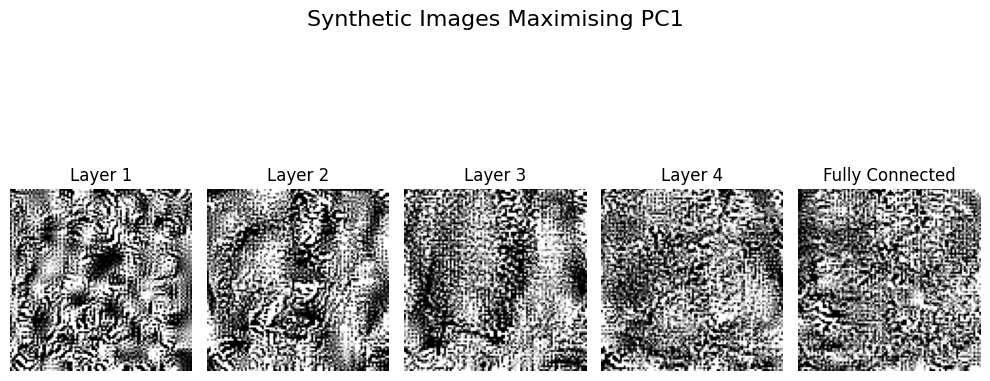

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(10, 5))
axs[0].imshow(img_layer1, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Layer 1")

axs[1].imshow(img_layer2, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Layer 2")

axs[2].imshow(img_layer3, cmap='gray')
axs[2].axis('off')
axs[2].set_title("Layer 3")

axs[3].imshow(img_layer4, cmap='gray')
axs[3].axis('off')
axs[3].set_title("Layer 4")

axs[4].imshow(img_fc, cmap='gray')
axs[4].axis('off')
axs[4].set_title("Fully Connected")

plt.suptitle(f"Synthetic Images Maximising PC1", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

14:57:32 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


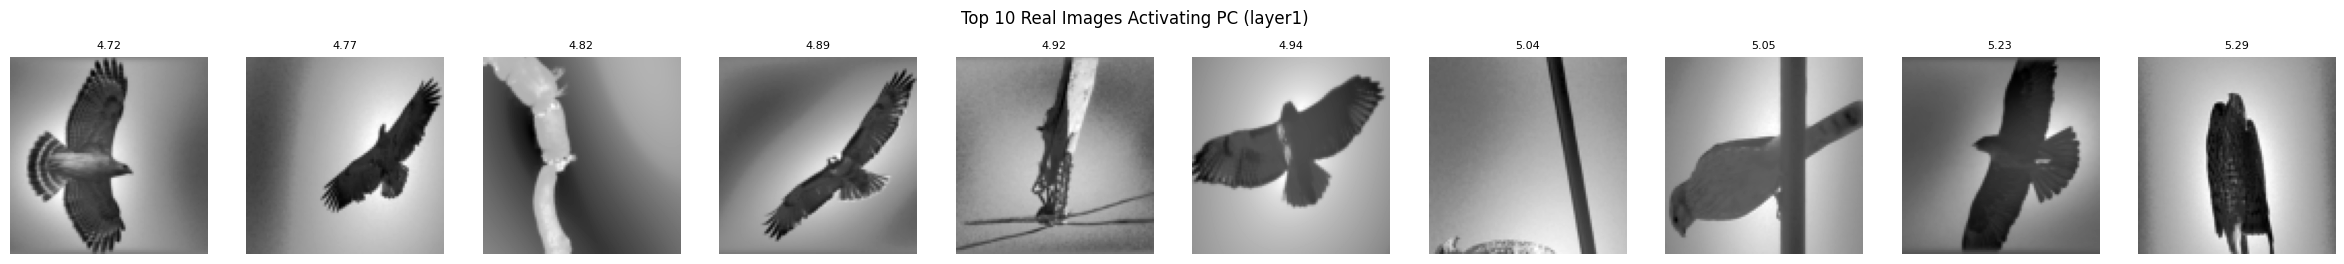

14:57:42 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


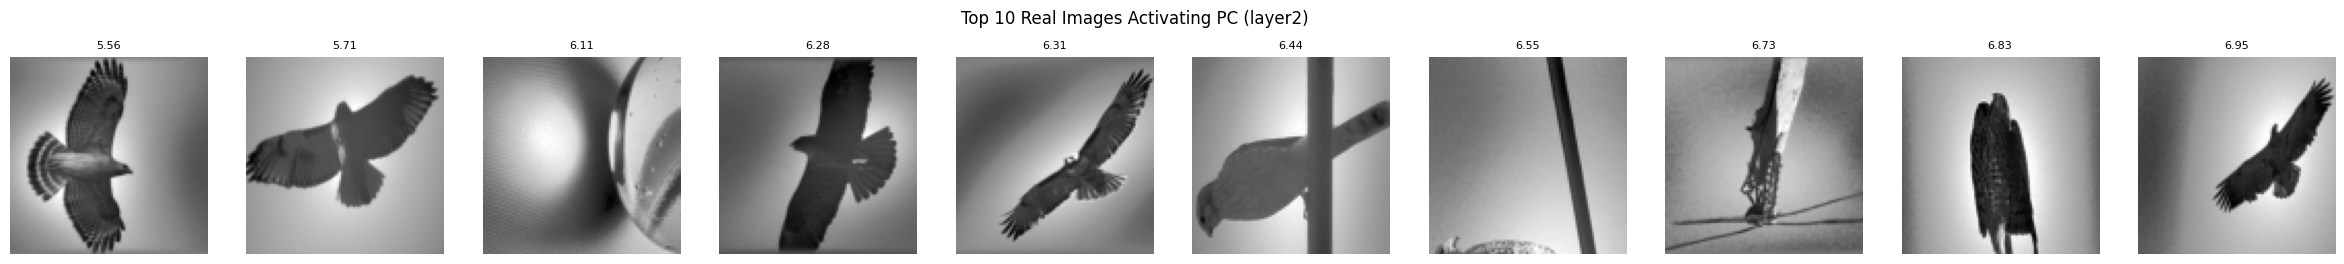

14:57:52 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


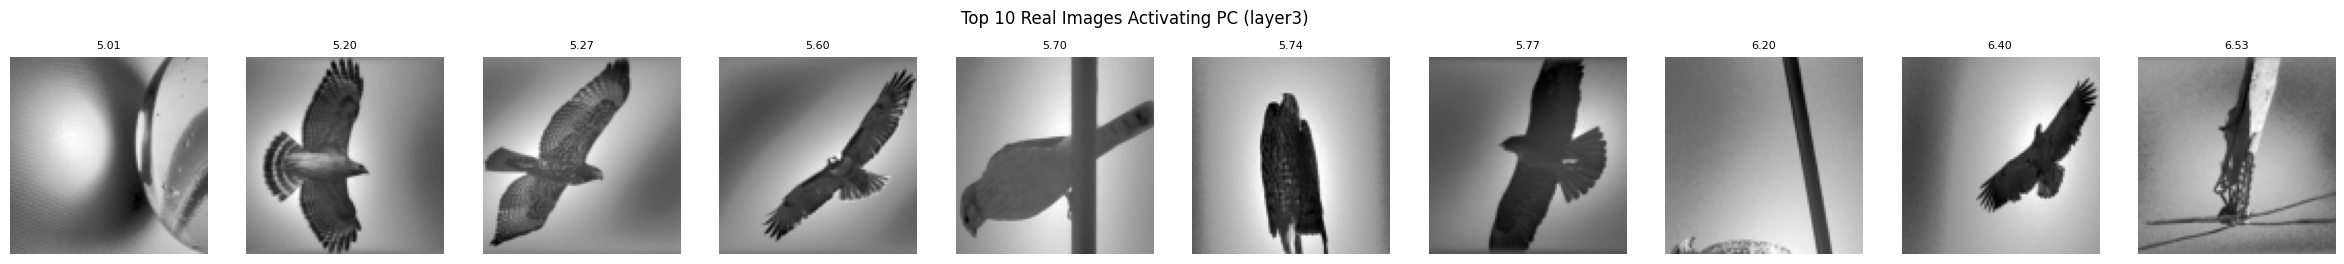

14:58:01 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


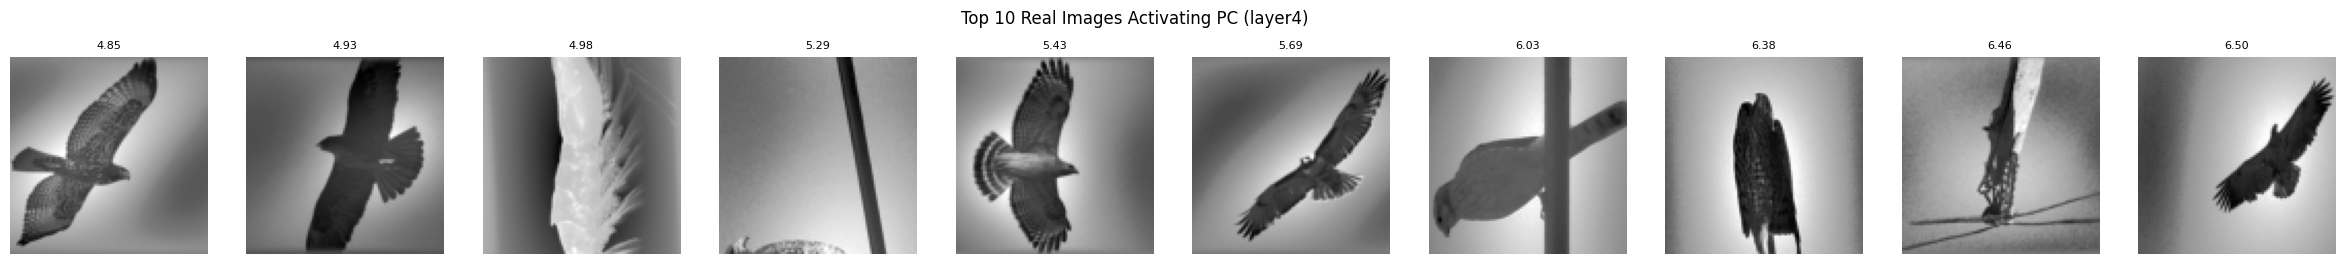

14:58:11 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


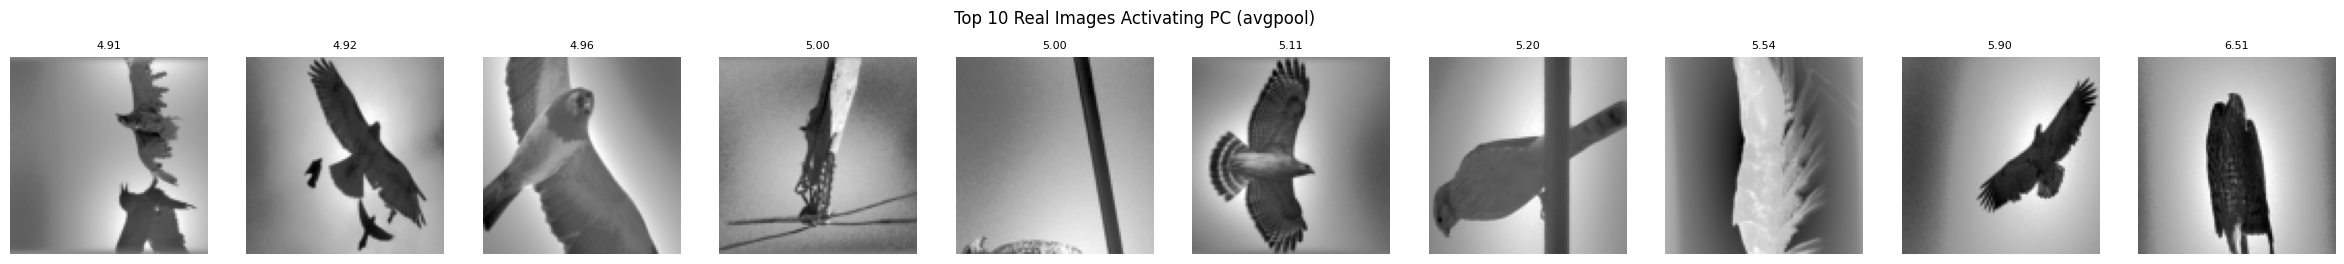

In [16]:
def show_top_pc_images(sim_clr, real_images, regressor, layer_name='layer2', top_k=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sim_clr.eval().to(device)

    # Hook to capture layer output
    intermediate_features = {}
    def hook_fn(module, input, output):
        intermediate_features[layer_name] = output

    layer = dict([*sim_clr.convnet.named_modules()])[layer_name]
    hook_handle = layer.register_forward_hook(hook_fn)

    # Preprocess real images
    real_images = real_images.to(device)
    if real_images.shape[1] == 1:
        real_imgs_3ch = real_images.repeat(1, 3, 1, 1)
    else:
        real_imgs_3ch = real_images

    with torch.no_grad():
        _ = sim_clr.convnet(real_imgs_3ch)
        feats = intermediate_features[layer_name].view(real_imgs_3ch.size(0), -1).cpu().numpy()

    hook_handle.remove()

    # Predict PC-N scores and find top-k images
    pc_N_preds = regressor.predict(feats)
    top_indices = np.argsort(pc_N_preds)[-top_k:]
    top_imgs = real_images[top_indices].cpu().squeeze()

    # Plot
    fig, axs = plt.subplots(1, top_k, figsize=(3 * top_k, 3))
   
    for i, img in enumerate(top_imgs):
        if img.ndim == 3 and img.shape[0] == 3:  # 3-channel
            axs[i].imshow(img[0], cmap='gray')  # Just show one channel
        else:
            axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Rank {top_k - i}")
        axs[i].set_title(f"{pc_N_preds[top_indices[i]]:.2f}", fontsize=8)

    plt.suptitle(f"Top {top_k} Real Images Activating PC ({layer_name})")
    plt.show()

### Show images that most activate PC1
show_top_pc_images(PreTrainedSimCLRModel(), image_dataset.tensors[0], ridge_layer1, layer_name='layer1', top_k=10)
show_top_pc_images(PreTrainedSimCLRModel(), image_dataset.tensors[0], ridge_layer2, layer_name='layer2', top_k=10)
show_top_pc_images(PreTrainedSimCLRModel(), image_dataset.tensors[0], ridge_layer3, layer_name='layer3', top_k=10)
show_top_pc_images(PreTrainedSimCLRModel(), image_dataset.tensors[0], ridge_layer4, layer_name='layer4', top_k=10)
show_top_pc_images(PreTrainedSimCLRModel(), image_dataset.tensors[0], ridge_fc, layer_name='avgpool', top_k=10)